# Przygotowanie środowiska Collab

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!apt-get install lzop

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  lzop
0 upgraded, 1 newly installed, 0 to remove and 31 not upgraded.
Need to get 39.8 kB of archives.
After this operation, 97.3 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 lzop amd64 1.03-4 [39.8 kB]
Fetched 39.8 kB in 0s (166 kB/s)
Selecting previously unselected package lzop.
(Reading database ... 160983 files and directories currently installed.)
Preparing to unpack .../archives/lzop_1.03-4_amd64.deb ...
Unpacking lzop (1.03-4) ...
Setting up lzop (1.03-4) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [6]:
%whos

Variable              Type         Data/Info
--------------------------------------------
all_features          list         n=20
all_features_to_idx   dict         n=20
df                    DataFrame                             <...>\n[250 rows x 24 columns]
labels                list         n=4
labels_to_idx         dict         n=4
np                    module       <module 'numpy' from '/us<...>kages/numpy/__init__.py'>
package_name          str          /content/drive/Shareddriv<...>5049Z&X-Goog-Expires=2592
package_name_2        str          /content/drive/Shareddriv<...>5049Z&X-Goog-Expires=2592
pd                    module       <module 'pandas' from '/u<...>ages/pandas/__init__.py'>
plt                   module       <module 'matplotlib.pyplo<...>es/matplotlib/pyplot.py'>
subprocess            module       <module 'subprocess' from<...>python3.7/subprocess.py'>
unpack_to_df          function     <function unpack_to_df at 0x7f5fe2fde320>


# Pobranie danych

In [ ]:
!cd /content/drive/Shareddrives/RecSys21/training && wget -i training_urls.txt

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.

part-00060.lzo.inde 100%[===================>]  47.43K  --.-KB/s    in 0.001s  

2021-04-11 13:38:56 (37.6 MB/s) - ‘part-00060.lzo.index?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115054Z&X-Goog-Expire’ saved [48568/48568]

The name is too long, 794 chars total.
Trying to shorten...
New name is part-00061.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115054Z&X-Goog-Expires=2592.
--2021-04-11 13:38:56--  https://storage.googleapis.com/twttr-recsys-2021-data/recsys2021/recsys_data/latest/training/pivoted_tsv/part-00061.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc%40twttr-recsys-2021-d

In [ ]:
!cd /content/drive/Shareddrives/RecSys21/ && wget https://storage.googleapis.com/twttr-recsys-2021-data/recsys2021/recsys_data/latest/training/tsv_deleted_engaged_with_tweet_id/part-00000
!cd /content/drive/Shareddrives/RecSys21/ && wget https://storage.googleapis.com/twttr-recsys-2021-data/recsys2021/recsys_data/latest/training/tsv_deleted_user_id/part-00000

--2021-04-11 14:55:52--  https://storage.googleapis.com/twttr-recsys-2021-data/recsys2021/recsys_data/latest/training/tsv_deleted_engaged_with_tweet_id/part-00000
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.115.128, 172.253.122.128, 172.253.63.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.115.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 969857724 (925M) [application/octet-stream]
Saving to: ‘part-00000’

part-00000          100%[===================>] 924.93M  55.3MB/s    in 19s     

2021-04-11 14:56:12 (47.7 MB/s) - ‘part-00000’ saved [969857724/969857724]

--2021-04-11 14:56:12--  https://storage.googleapis.com/twttr-recsys-2021-data/recsys2021/recsys_data/latest/training/tsv_deleted_user_id/part-00000
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 172.217.13.240, 172.217.15.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... 

# Wczytywanie jednej paczki do DataFrame

In [2]:
import subprocess
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
all_features = ["text_ tokens", "hashtags", "tweet_id", "present_media", "present_links", "present_domains",\
                "tweet_type","language", "tweet_timestamp", "engaged_with_user_id", "engaged_with_user_follower_count",\
               "engaged_with_user_following_count", "engaged_with_user_is_verified", "engaged_with_user_account_creation",\
               "enaging_user_id", "enaging_user_follower_count", "enaging_user_following_count", "enaging_user_is_verified",\
               "enaging_user_account_creation", "engagee_follows_engager"]
labels = ["reply_timestamp", "retweet_timestamp", "retweet_with_comment_timestamp", "like_timestamp"]

all_features_to_idx = dict(zip(all_features, range(len(all_features))))
labels_to_idx = dict(zip(labels, range(len(all_features), len(all_features)+len(labels))))

In [14]:
def unpack_to_df(package_name, sslice=None):
  out = subprocess.Popen(['lzop', '-dc', package_name], \
            stdout=subprocess.PIPE, \
            stderr=subprocess.STDOUT)
  lines, stderr = out.communicate()
  lines = lines.decode('utf-8').split('\n')
  if sslice is not None:
    lines = lines[sslice]
  lines = list(map(lambda line: line.split("\x01"), lines))
  lines = pd.DataFrame(lines, columns=all_features + labels)
  return lines

In [5]:
%%time

package_name = "/content/drive/Shareddrives/RecSys21/training/part-00000.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"
df = unpack_to_df(package_name)

CPU times: user 4.73 s, sys: 5.15 s, total: 9.88 s
Wall time: 24.7 s


# Podstawowe statystyki

In [9]:
df.describe()

,text_ tokens,hashtags,tweet_id,present_media,present_links,present_domains,tweet_type,language,tweet_timestamp,engaged_with_user_id,engaged_with_user_follower_count,engaged_with_user_following_count,engaged_with_user_is_verified,engaged_with_user_account_creation,enaging_user_id,enaging_user_follower_count,enaging_user_following_count,enaging_user_is_verified,enaging_user_account_creation,engagee_follows_engager,reply_timestamp,retweet_timestamp,retweet_with_comment_timestamp,like_timestamp
count,3300771,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770,3300770
unique,2812148,315247,3041137,17,303962,56888,3,66,1449863,1619504,122982,30959,2,1615081,2303793,23358,13822,2,2291914,2,91987,265387,22783,925225
top,101\t100\t102,,AE62799DC2A663D542FB92AAF531E5D1,,,,TopLevel,488B32D24BD4BB44172EB981C1BCA6FA,1612752917,D956CB05C8566B63F75C86A595A84417,12399443,0,false,1267828720,DA0026BDA7CA28C0DB8A89BC0C783F55,0,96,false,1559503200,false,,,,
freq,14227,2632600,124,2041604,2920389,2920389,1952361,1204895,129,2240,2240,29847,2661568,2240,93,17552,7044,3294974,93,1931076,3206319,3012818,3277834,1992113


## Wzorce występujące w labelach

In [39]:
df[labels].astype(bool).astype(str).agg('-'.join, axis=1).value_counts()

False-False-False-False    1663700
False-False-False-True     1242254
False-True-False-False      228175
True-False-False-False       79331
False-True-False-True        49607
False-False-True-False       12709
True-False-False-True        12595
False-True-True-False         6396
False-False-True-True         2022
True-True-False-False         1521
False-True-True-True          1457
True-True-False-True           652
True-False-True-False          166
True-True-True-False           116
True-False-True-True            42
True-True-True-True             28
dtype: int64

## Relacje czasowe

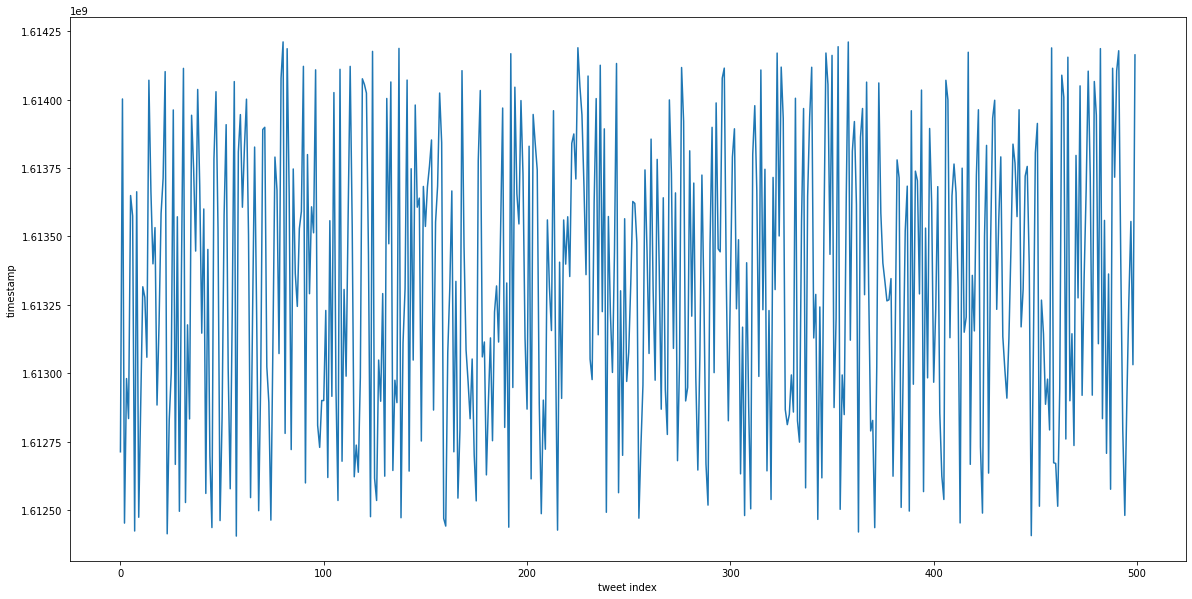

In [25]:
x = df['tweet_timestamp'][:500].astype('int64')
plt.figure(figsize=(20,10))
plt.plot(range(len(x)), x)
plt.xlabel('tweet index')
plt.ylabel('timestamp')
plt.show()

In [36]:
package_name_1 = "/content/drive/Shareddrives/RecSys21/training/part-00000.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"
package_name_2 = "/content/drive/Shareddrives/RecSys21/training/part-00001.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"

# Zabija sesję

# df2 = unpack_to_df(package_name_2)

# Idea - wczytywanie części df

df1 = unpack_to_df(package_name_1, sslice=slice(-251, -1)) # Nie mamy ostatniej reakcji w paczce
df2 = unpack_to_df(package_name_2, sslice=slice(0, 250))

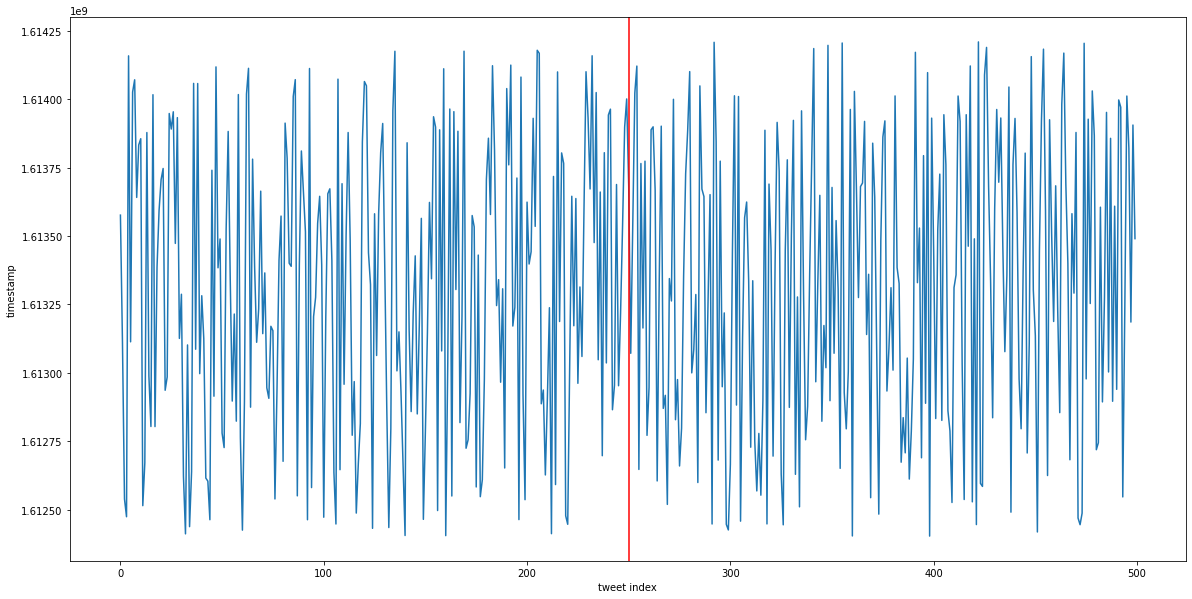

In [43]:
# ostatnie 250 tweetów z pierwszej paczki (bez jednego ostatniego) i pierwsze 250 z kolejnej paczki
x = list(df1['tweet_timestamp'].astype('int64')) + list(df2['tweet_timestamp'].astype('int64'))
plt.figure(figsize=(20,10))
plt.plot(range(len(x)), x)
plt.axvline(250, color='red')
plt.xlabel('tweet index')
plt.ylabel('timestamp')
plt.show()

In [9]:
# może po sortowaniu wszystkich reakcji według timestamp będzie lepiej? 

package_name_1 = "/content/drive/Shareddrives/RecSys21/training/part-00000.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"
package_name_2 = "/content/drive/Shareddrives/RecSys21/training/part-00001.lzo?X-Goog-Algorithm=GOOG4-RSA-SHA256&X-Goog-Credential=recsys2021-website-service-acc@twttr-recsys-2021-dev.iam.gserviceaccount.com%2F20210411%2Fauto%2Fstorage%2Fgoog4_request&X-Goog-Date=20210411T115049Z&X-Goog-Expires=2592"

# bez tego znowu zabraknie pamięci
def get_timestamps(package_name):
  out = subprocess.Popen(['lzop', '-dc', package_name], \
            stdout=subprocess.PIPE, \
            stderr=subprocess.STDOUT)
  lines, stderr = out.communicate()
  lines = lines.decode('utf-8').split('\n')
  lines = lines[:-1] # last is empty
  feature_idx = all_features_to_idx['tweet_timestamp']
  timestamps = np.array(list(map(lambda line: line.split("\x01")[feature_idx], lines))).astype('int64')
  return timestamps

t1 = get_timestamps(package_name_1)
t2 = get_timestamps(package_name_2)

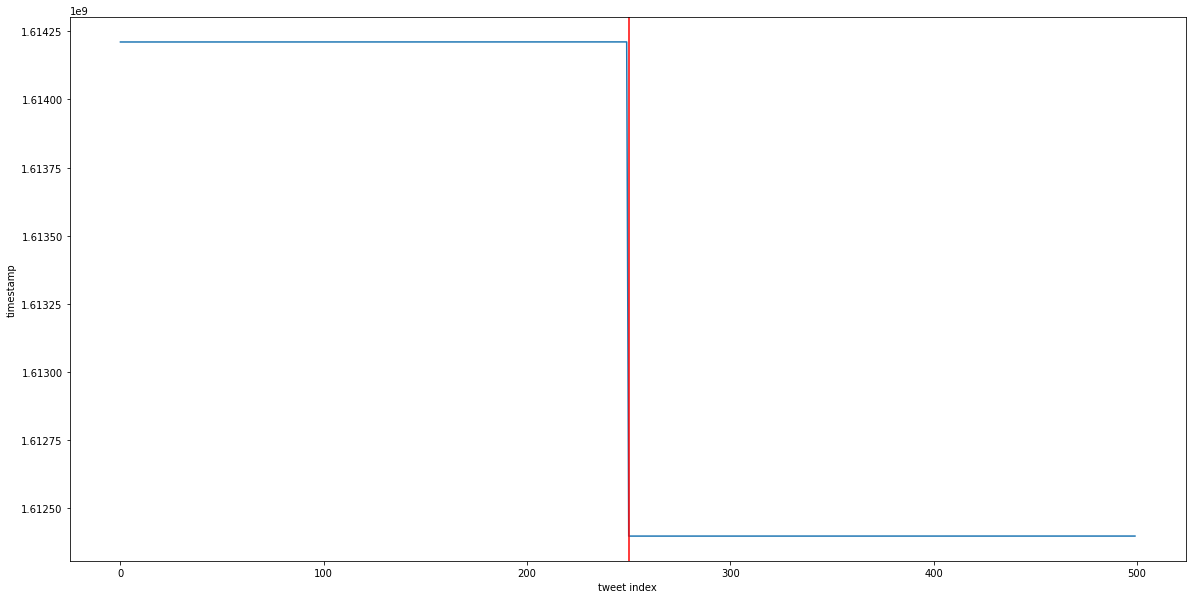

In [21]:
last_t1 = np.sort(t1)[-250:]
first_t2 = np.sort(t2)[:250]
x = list(last_t1) + list(first_t2)
plt.figure(figsize=(20,10))
plt.plot(range(len(x)), x)
plt.axvline(250, color='red')
plt.xlabel('tweet index')
plt.ylabel('timestamp')
plt.show()

## Wnioski

### Dane
1. 3300770 reakcji
2. tweet_id != reakcję (92.13% unikalnych tweetów)
3. 17 typów media - 66.85% reakcji nie ma mediów
4. 88.47% reakcji nie zawiera linków (identycznie dla tweetów zawierające domeny)
5. 66 języków - 36,5% reakcji na tweety w najbardziej popularnym (angielski?)
6. Paczka zawiera 2240 reakcji dla jednego z "Engaged With" Usera
7. Średnio po dwie reakcji na "Engaged With" usera (49.06% unikalnych engaged_with_user_id)
8. Najpopularniejsza ilość osób, którą followuje "Engaged With" User dla reakcji w tej paczce  - 0 (0.9% takich reakcji)
9. 80.63% reakcji na nie zweryfikowane konta "Engaged With" userów 
10. Paczka zawiera 93 reakcji dla jednego z "Engaging" Usera
11. W 58.5% reakcjach "engagee" nie followuje "engagera"
12. Top wykonywanych akcji:
  * 50.4% - Żadnej akcji
  * 37.6% - tylko like
-----------------

### Zależności czasowe
1. Z ananlizy pierszych 500 tweetów wynika, że reakcje są nieposortowane czasowo
2. Pierwsze 250 tweeetów z paczki nie występują czasowo po pierszych 250 tweetach kolejnej paczki
3. 2 punkt zachodzi nawet jeśli posortujemy względem czasu reakcje w obu kolejnych paczkach
------------------

### Inne uwagi

1. Półtory minuty na wczytywanie paczki do pamięci na colabie
2. Wczytywanie dwóch paczek do pamięci na colabie zabija sesję - kończy się RAM